# Bayesian Regression in Pyro: GDP and Terrain Ruggedness

1. [Introduction](#1.-Introduction)
2. [Dataset](#2.-Dataset)
3. [Bayesian Linear Regression](#3.-Bayesian-Linear-Regression)
    1. [Model](#3.1.-Model)
    2. [SVI with an AutoDiagonalNormal Guide](3.2.-SVI-with-AutoDiagonalNormal-Guide)
    3. [Exact Inference Using Hamiltonian Monte Carlo](#3.3-Exact-Inference-using-Hamiltonian-Monte-Carlo)
    4. [Better Posterior Approximation Using AutoMultivariateNormal Guide]
4. [Model Predictions]

### 1. Introduction

The following simple bayesian regression example is adapted from \[1\]. We will use the dataset from \[2\], replicate the authors' central point in the paper (see below), and use this to motivate different ways of doing bayesian regression in Pyro - i.e. faster and scalable approximate inference via Variational Inference, or exact (though slower) inference via Hamiltonian Monte Carlo.

*Abstract - Ruggedness: The blessing of bad geography in Africa*


> We show that geography, through its impact on history, can have important effects on current economic development. The analysis focuses on the historic interaction between ruggedness and Africa's slave trades. Although rugged terrain hinders trade and most productive activities, negatively affecting income globally, within Africa rugged terrain afforded protection to those being raided during the slave trades. Since the slave trades retarded subsequent economic development, within Africa ruggedness has also had a historic indirect positive effect on income. Studying all countries worldwide, we estimate the differential effect of ruggedness on income for Africa. We show that the differential effect of ruggedness is statistically significant and economically meaningful, it is found in Africa only, it cannot be explained by other factors like Africa's unique geographic environment, and it is fully accounted for by the history of the slave trades.


  1. McElreath, D., *Statistical Rethinking, Chapter 7*, 2016
  2. Nunn, N. & Puga, D., *[Ruggedness: The blessing of bad geography in Africa"](https://diegopuga.org/papers/rugged.pdf)*, Review of Economics and Statistics 94(1), Feb. 2012

In [1]:
from __future__ import absolute_import, division, print_function

import argparse
from functools import partial
import logging
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch

import pyro
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.distributions.util import logsumexp
from pyro.infer import EmpiricalMarginal, SVI, Trace_ELBO
from pyro.infer.abstract_infer import TracePredictive
from pyro.infer.mcmc import MCMC, NUTS
import pyro.optim as optim
import pyro.poutine as poutine

In [2]:
%matplotlib inline
logging.basicConfig(format='%(message)s', level=logging.INFO)
# Enable validation checks
pyro.enable_validation(True)
pyro.set_rng_seed(1)
DATA_URL = "https://d2fefpcigoriu7.cloudfront.net/datasets/rugged_data.csv"

### 2. Dataset 

We would like to explore the relationship between topographic heterogeneity of a nation as measured by the Terrain Ruggedness Index (variable *rugged* in the dataset) and its GDP. In particular, it was noted by the authors in \[2\] that terrain ruggedness or bad geography is related to poorer economic performance outside of Africa, but rugged terrains have had a reverse effect on income for African nations. Let us look at the dataset and plot this relationship.

We will be using only three columns from the dataset:
  - `rugged`: quantifies the Terrain Ruggedness Index
  - `cont_africa`: whether the given nation is in Africa
  - `rgdppc_2000`: Real GDP per capita for the year 2000
  
We will also take the logarithm for the response variable, GDP. This is a common practice as the relationship of wealth to its causal factors is often exponential due to the *rich get richer phenomenon*.

In [3]:
rugged_data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")

In [4]:
rugged_data.head()

,isocode,isonum,country,rugged,rugged_popw,rugged_slope,rugged_lsd,rugged_pc,land_area,lat,...,africa_region_w,africa_region_e,africa_region_c,slave_exports,dist_slavemkt_atlantic,dist_slavemkt_indian,dist_slavemkt_saharan,dist_slavemkt_redsea,pop_1400,european_descent
0,ABW,533,Aruba,0.462,0.380,1.226,0.144,0.000,18.0,12.508,...,0,0,0,0.0,NaN,NaN,NaN,NaN,614.0,NaN
1,AFG,4,Afghanistan,2.518,1.469,7.414,0.720,39.004,65209.0,33.833,...,0,0,0,0.0,NaN,NaN,NaN,NaN,1870829.0,0.0
2,AGO,24,Angola,0.858,0.714,2.274,0.228,4.906,124670.0,-12.299,...,0,0,1,3610000.0,5.669,6.981,4.926,3.872,1223208.0,2.0
3,AIA,660,Anguilla,0.013,0.010,0.026,0.006,0.000,9.0,18.231,...,0,0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,ALB,8,Albania,3.427,1.597,10.451,1.006,62.133,2740.0,41.143,...,0,0,0,0.0,NaN,NaN,NaN,NaN,200000.0,100.0


[Text(0,0.5,'log GDP (2000)'),
 Text(0.5,0,'Terrain Ruggedness Index'),
 Text(0.5,1,'African Nations')]

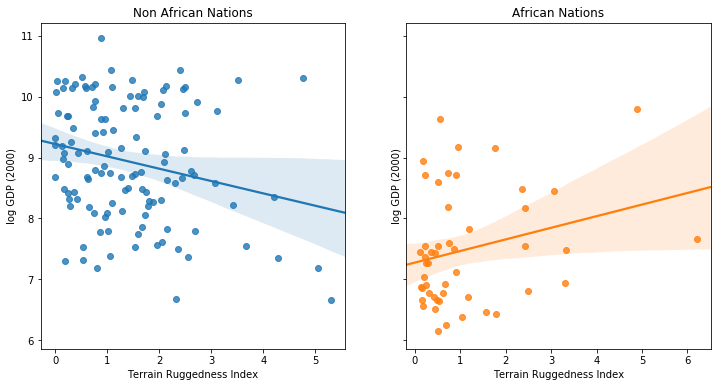

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = rugged_data[rugged_data["cont_africa"] == 1]
non_african_nations = rugged_data[rugged_data["cont_africa"] == 0]
sns.regplot(non_african_nations["rugged"], 
            np.log(non_african_nations["rgdppc_2000"]), 
            ax=ax[0])
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
sns.regplot(african_nations["rugged"], 
            np.log(african_nations["rgdppc_2000"]), 
            ax=ax[1])
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations")

As can be seen from the figure above, for most nations ruggedness corresponds to lower GDP per capita. This can be attributed to multiple reasons, transporation and hence trade difficulties being the chief one. We also observe a reversal in this relationship for African nations - i.e. higher terrain ruggedness generally corresponds to higher GDP per capita. The authors posit that more rugged terrains were an important factor in protecting nations from slave traders historically, which tended to have positive effects on income later.

### 3. Bayesian Linear Regression

Let us try to use bayesian linear regression to see if we can capture and quantify this relationship. We would like to predict log GDP per capita of a nation as a function of two features from the dataset - whether the nation is in Africa, and its Terrain Ruggedness Index.

### 3.1. Model

The model below specifies the generative process. `bA` and `bR` are regression coefficients corresponding to  `is_cont_africa` and `ruggedness`, `a` is the intercept. Note that simple linear regression cannot account for a reversal in the relationship between one of the predictors and the response. There is an interaction between `is_cont_africa` and `rugged`, and the simplest way to incorporate this interaction effect in the model is through a linear interaction term `is_cont_africa x rugged`. The regression coefficient for this is given by `bAR`. 

Note the priors that we are using for the different latent variables in the model. The prior on the intercept parameter is very flat as we would like this to be learnt from the data. We are using a weakly regularizing prior on the regression coefficients to avoid overfitting to the data, and a noninformative prior on `sigma`.

In [33]:
def model(is_cont_africa, ruggedness):
    a = pyro.sample("a", dist.Normal(8., 1000.))
    b_a = pyro.sample("bA", dist.Normal(0., 1.))
    b_r = pyro.sample("bR", dist.Normal(0., 1.))
    b_ar = pyro.sample("bAR", dist.Normal(0., 1.))
    sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
    mu = a + b_a * is_cont_africa + b_r * ruggedness + b_ar * is_cont_africa * ruggedness
    with pyro.iarange("data", len(ruggedness)):
        pyro.sample("obs", dist.Normal(mu, sigma))

In [34]:
def conditioned_model(log_gdp, *args, **kwargs):
    return poutine.condition(model, data={"obs": log_gdp})(*args, **kwargs)

In [35]:
# Utility functions

def summary(traces, sites):
    marginal = EmpiricalMarginal(traces, sites).get_samples_and_weights()[0].detach().cpu().numpy()
    site_stats = {}
    for i in range(marginal.shape[1]):
        site_name = sites[i]
        marginal_site = pd.DataFrame(marginal[:, i]).transpose()
        describe = partial(pd.Series.describe, percentiles=[.05, 0.25, 0.5, 0.75, 0.95])
        site_stats[site_name] = marginal_site.apply(describe, axis=1) \
            [["mean", "std", "5%", "25%", "50%", "75%", "95%"]]
    return site_stats

# Prepare training data
df = rugged_data[["cont_africa", "rugged", "rgdppc_2000"]]
df = df[np.isfinite(df.rgdppc_2000)]
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])
train = torch.tensor(df.values, dtype=torch.float)

### 3.2. SVI with AutoDiagonalNormal Guide

To fit our bayesian linear regression model, we will use Variational Inference with an automatically constructed guide that samples the latent variables from a gaussian distribution with a diagonal covariance matrix.

In [36]:
guide = AutoDiagonalNormal(conditioned_model)
svi = SVI(conditioned_model, 
          guide, 
          optim.Adam({"lr": .005}), 
          loss=Trace_ELBO(), 
          num_samples=1000)
is_cont_africa, ruggedness, log_gdp = train[:, 0], train[:, 1], train[:, 2]
pyro.clear_param_store()
for i in range(10000):
    elbo = svi.step(log_gdp, is_cont_africa, ruggedness)
    if i % 500 == 0:
        logging.info("Elbo loss: {}".format(elbo))

Elbo loss: 687.06097894907
Elbo loss: 642.0917519330978
Elbo loss: 582.5888718366623
Elbo loss: 576.6002059578896
Elbo loss: 563.9409103393555
Elbo loss: 537.2074866294861
Elbo loss: 521.0771135091782
Elbo loss: 514.0810322165489
Elbo loss: 468.1431220769882
Elbo loss: 483.21634542942047
Elbo loss: 410.86647498607635
Elbo loss: 439.73468255996704
Elbo loss: 320.88163191080093
Elbo loss: 270.4268254637718
Elbo loss: 326.6693180799484
Elbo loss: 258.6502144932747
Elbo loss: 251.19403845071793
Elbo loss: 254.2570520043373
Elbo loss: 256.07813650369644
Elbo loss: 252.71863919496536


In [37]:
svi_diagnorm_posterior = svi.run(log_gdp, is_cont_africa, ruggedness)

Let us observe the posterior distribution over the different latent variables in the model.

In [39]:
sites = ["a", "bA", "bR", "bAR", "sigma"]

for site, values in summary(svi_diagnorm_posterior, sites).items():
    print("Site: {}".format(site))
    print(values, "\n")

Site: a
       mean       std        5%       25%       50%       75%       95%
0  9.184932  0.076325  9.062339  9.132092  9.186984  9.239982  9.312705 

Site: bA
      mean       std        5%       25%       50%       75%       95%
0 -1.85073  0.138185 -2.087591 -1.942521 -1.851592 -1.754753 -1.626257 

Site: bR
       mean       std        5%       25%       50%       75%       95%
0 -0.188615  0.043076 -0.257786 -0.217457 -0.188747 -0.159529 -0.118365 

Site: bAR
       mean      std        5%       25%       50%       75%       95%
0  0.337553  0.07637  0.210556  0.287203  0.333721  0.385895  0.470401 

Site: sigma
       mean      std        5%       25%       50%      75%       95%
0  0.948269  0.09567  0.796481  0.883479  0.943809  1.01036  1.098607 



### 3.3 Exact Inference using Hamiltonian Monte Carlo

In contrast to using Variational Inference which gives us a approximate posterior over our latent variables, we can also do exact inference using MCMC. The algorithm that we will be using is called the No-U Turn Sampler (NUTS), which provides an efficient and automated way of running Hamiltonian Monte Carlo.

In [40]:
nuts_kernel = NUTS(conditioned_model, adapt_step_size=True)

hmc_posterior = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200) \
    .run(log_gdp, is_cont_africa, ruggedness)

INFO 	 Starting MCMC using kernel - NUTS ...
INFO 	 Iteration: 60 [WARMUP]
INFO 	 Step size: 0.043863 	 Acceptance rate: 0.866667
INFO 	 Iteration: 120 [WARMUP]
INFO 	 Step size: 0.030094 	 Acceptance rate: 0.900000
INFO 	 Iteration: 180 [WARMUP]
INFO 	 Step size: 0.030291 	 Acceptance rate: 0.911111
INFO 	 Iteration: 240 [SAMPLE]
INFO 	 Step size: 0.041947 	 Acceptance rate: 0.925000
INFO 	 Iteration: 300 [SAMPLE]
INFO 	 Step size: 0.041947 	 Acceptance rate: 0.936667
INFO 	 Iteration: 360 [SAMPLE]
INFO 	 Step size: 0.041947 	 Acceptance rate: 0.941667
INFO 	 Iteration: 420 [SAMPLE]
INFO 	 Step size: 0.041947 	 Acceptance rate: 0.945238
INFO 	 Iteration: 480 [SAMPLE]
INFO 	 Step size: 0.041947 	 Acceptance rate: 0.950000
INFO 	 Iteration: 540 [SAMPLE]
INFO 	 Step size: 0.041947 	 Acceptance rate: 0.951852
INFO 	 Iteration: 600 [SAMPLE]
INFO 	 Step size: 0.041947 	 Acceptance rate: 0.953333
INFO 	 Iteration: 660 [SAMPLE]
INFO 	 Step size: 0.041947 	 Acceptance rate: 0.954545
INFO 	 Ite

In [41]:
for site, values in summary(hmc_posterior, sites).items():
    print("Site: {}".format(site))
    print(values, "\n")

Site: a
      mean       std        5%       25%       50%       75%       95%
0  9.18662  0.146052  8.943762  9.087727  9.184378  9.291018  9.412624 

Site: bA
       mean       std        5%       25%       50%      75%       95%
0 -1.831624  0.242007 -2.212127 -1.998865 -1.834094 -1.67699 -1.441538 

Site: bR
      mean      std        5%       25%       50%      75%       95%
0 -0.18763  0.07977 -0.316085 -0.241417 -0.187355 -0.13614 -0.053473 

Site: bAR
       mean       std        5%       25%      50%      75%       95%
0  0.343592  0.139052  0.107897  0.260019  0.35157  0.43828  0.555267 

Site: sigma
      mean       std        5%       25%       50%       75%       95%
0  0.95153  0.052784  0.870467  0.913028  0.948125  0.987978  1.042386 



### 3.4 Comparing Posterior Distributions

Let us compare the posterior distribution of the latent variables that we obtained from Variational Inference with those from Hamiltonian Monte Carlo. As can be seen below, for Variational Inference, the marginal distribution of the different regression coefficients is under-dispersed w.r.t. the true posterior (from HMC). This is an artifact of the *KL(q||p)* loss that is minimized by Variational Inference.

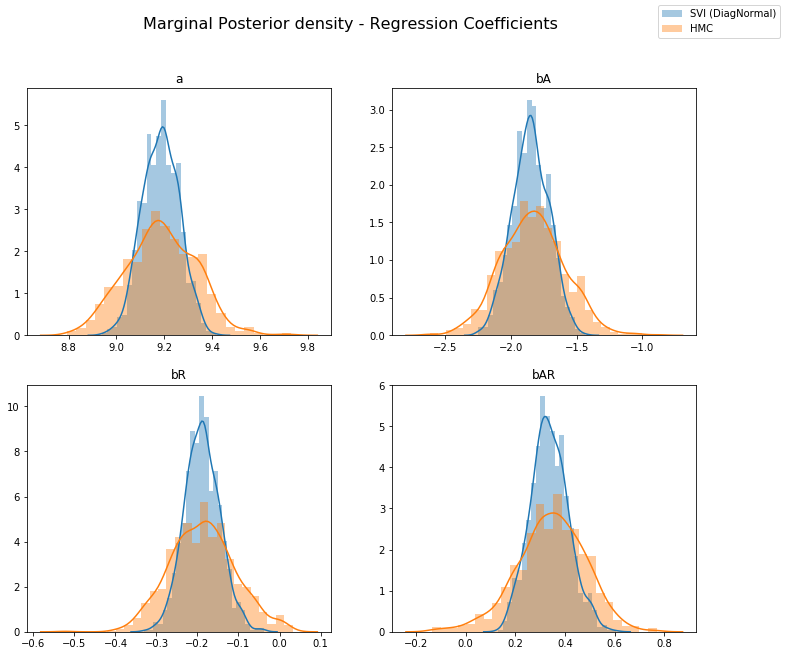

In [42]:
svi_diagnorm_empirical = EmpiricalMarginal(svi_diagnorm_posterior, sites=sites) \
                         .get_samples_and_weights()[0] \
                         .detach().cpu().numpy()
hmc_empirical = EmpiricalMarginal(hmc_posterior, sites=sites).get_samples_and_weights()[0].numpy()
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
fig.suptitle("Marginal Posterior density - Regression Coefficients", fontsize=16)
for i, ax in enumerate(axs.reshape(-1)):
    sns.distplot(svi_diagnorm_empirical[:, i], ax=ax, label="SVI (DiagNormal)")
    sns.distplot(hmc_empirical[:, i], ax=ax, label="HMC")
    ax.set_title(sites[i])
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

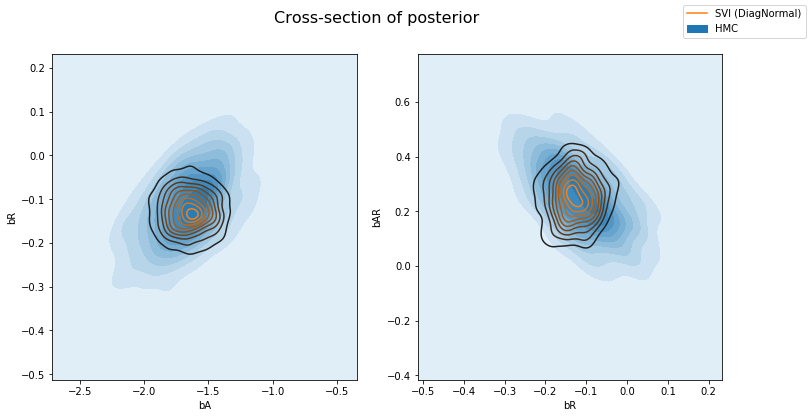

In [96]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle("Cross-section of posterior", fontsize=16)
sns.kdeplot(hmc_empirical[:, 1], hmc_empirical[:, 2], ax=axs[0], shade=True, label="HMC")
sns.kdeplot(svi_diagnorm_empirical[:, 1], svi_diagnorm_empirical[:, 2], ax=axs[0], label="SVI (DiagNormal)")
axs[0].set(xlabel="bA", ylabel="bR")
sns.kdeplot(hmc_empirical[:, 2], hmc_empirical[:, 3], ax=axs[1], shade=True, label="HMC")
sns.kdeplot(svi_diagnorm_empirical[:, 2], svi_diagnorm_empirical[:, 3], ax=axs[1], label="SVI (DiagNormal)")
axs[1].set(xlabel="bR", ylabel="bAR")
handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

### Comparison with SVI using Multivariate Normal Guide

In [89]:
guide = AutoMultivariateNormal(conditioned_model)
svi = SVI(conditioned_model, 
          guide, 
          optim.Adam({"lr": .005}), 
          loss=Trace_ELBO(), 
          num_samples=1000)
is_cont_africa, ruggedness, log_gdp = train[:, 0], train[:, 1], train[:, 2]
pyro.clear_param_store()
for i in range(10000):
    elbo = svi.step(log_gdp, is_cont_africa, ruggedness)
    if i % 500 == 0:
        logging.info("Elbo loss: {}".format(elbo))

Elbo loss: 619.90680372715
Elbo loss: 533.942104101181
Elbo loss: 438.93541502952576
Elbo loss: 448.034276843071
Elbo loss: 439.7798751592636
Elbo loss: 339.8986733555794
Elbo loss: 331.90865445137024
Elbo loss: 403.4365646839142
Elbo loss: 280.7670966386795
Elbo loss: 317.9036238193512
Elbo loss: 313.8227458000183
Elbo loss: 299.43476617336273
Elbo loss: 253.52992403507233
Elbo loss: 203.64813500642776
Elbo loss: 211.06482952833176
Elbo loss: 204.9407103061676
Elbo loss: 210.12182295322418
Elbo loss: 208.6727232336998
Elbo loss: 210.1912346482277
Elbo loss: 206.87474584579468


In [90]:
svi_mvn_posterior = svi.run(log_gdp, is_cont_africa, ruggedness)

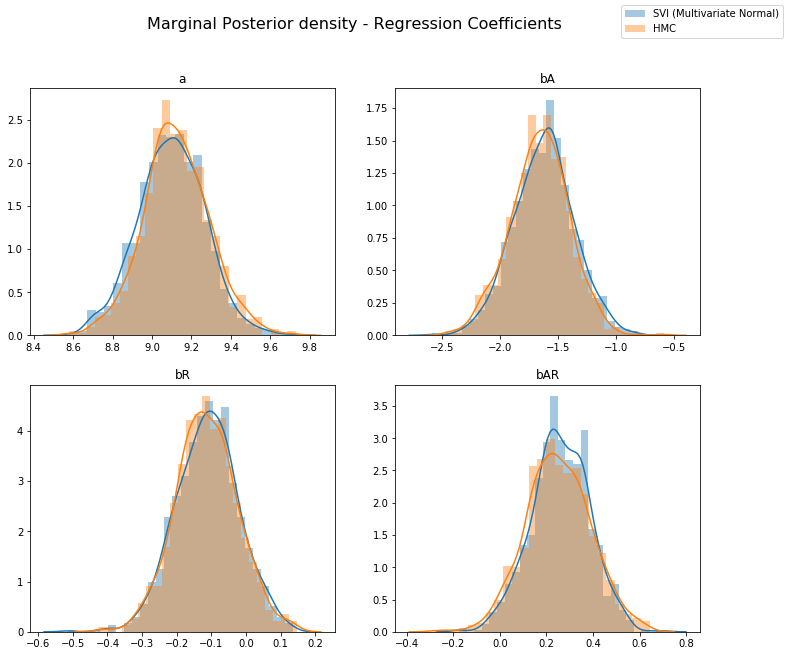

In [91]:
svi_mvn_empirical = EmpiricalMarginal(svi_mvn_posterior, sites=sites).get_samples_and_weights()[0] \
                    .detach().cpu().numpy()
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
fig.suptitle("Marginal Posterior density - Regression Coefficients", fontsize=16)
for i, ax in enumerate(axs.reshape(-1)):
    sns.distplot(svi_mvn_empirical[:, i], ax=ax, label="SVI (Multivariate Normal)")
    sns.distplot(hmc_empirical[:, i], ax=ax, label="HMC")
    ax.set_title(sites[i])
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

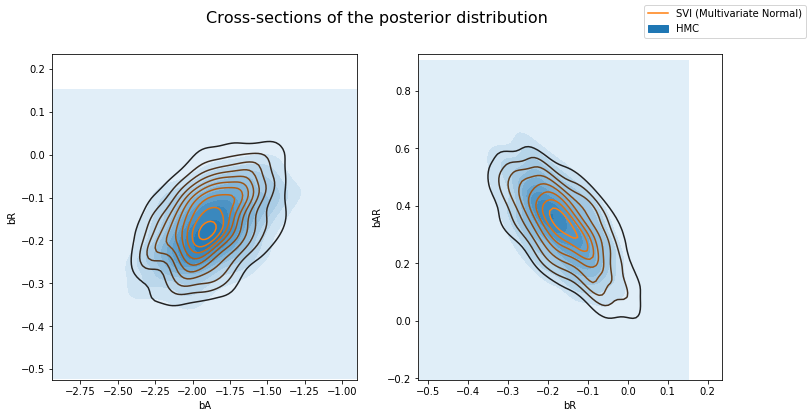

In [29]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle("Cross-sections of the posterior distribution", fontsize=16)
sns.kdeplot(hmc_empirical[:, 1], hmc_empirical[:, 2], ax=axs[0], shade=True, label="HMC")
sns.kdeplot(svi_mvn_empirical[:, 1], svi_mvn_empirical[:, 2], ax=axs[0], label="SVI (Multivariate Normal)")
axs[0].set(xlabel="bA", ylabel="bR")
sns.kdeplot(hmc_empirical[:, 2], hmc_empirical[:, 3], ax=axs[1], shade=True, label="HMC")
sns.kdeplot(svi_mvn_empirical[:, 2], svi_mvn_empirical[:, 3], ax=axs[1], label="SVI (Multivariate Normal)")
axs[1].set(xlabel="bR", ylabel="bAR")
handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

### Slope of Log GDP vs. Terrain Ruggedness 

Text(0.5,0.98,'Density of Slope : log(GDP) vs. terrain ruggedness')

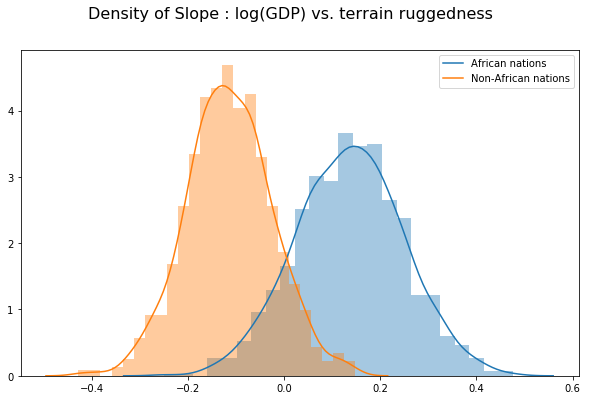

In [109]:
gamma_within_africa = hmc_empirical[:, 2] + hmc_empirical[:, 3]
gamma_outside_africa = hmc_empirical[:, 2]
fig = plt.figure(figsize=(10, 6))
sns.distplot(gamma_within_africa, kde_kws={"label": "African nations"},)
sns.distplot(gamma_outside_africa, kde_kws={"label": "Non-African nations"})
fig.suptitle("Density of Slope : log(GDP) vs. Terrain Ruggedness", fontsize=16)

### Model Predictions

In [104]:
trace_pred = TracePredictive(model,
                             hmc_posterior,
                             num_samples=1000)
post_pred = trace_pred.run(is_cont_africa, ruggedness)
predictions = summary(post_pred, sites=["obs"])["obs"]
predictions = pd.DataFrame({
    "cont_africa": train[:, 0],
    "rugged": train[:, 1],
    "gdp_mean": predictions["mean"],
    "gdp_perc_5": predictions["5%"],
    "gdp_perc_95": predictions["95%"],
    "true_gdp": train[:, 2]
})

[Text(0,0.5,'log GDP (2000)'),
 Text(0.5,0,'terrain ruggedness index'),
 Text(0.5,1,'African Nations')]

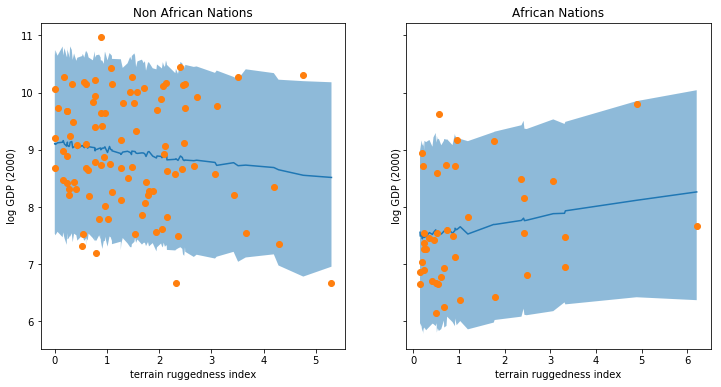

In [106]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = predictions[predictions["cont_africa"] == 1]
non_african_nations = predictions[predictions["cont_africa"] == 0]
african_nations = african_nations.sort_values(by=["rugged"])
non_african_nations = non_african_nations.sort_values(by=["rugged"])
ax[0].plot(non_african_nations["rugged"], 
           non_african_nations["gdp_mean"])
ax[0].fill_between(non_african_nations["rugged"], 
                   non_african_nations["gdp_perc_5"],
                   non_african_nations["gdp_perc_95"],
                   alpha=0.5)
ax[0].plot(non_african_nations["rugged"], 
           non_african_nations["true_gdp"],
           "o")
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
idx = np.argsort(african_nations["rugged"])
ax[1].plot(african_nations["rugged"], 
           african_nations["gdp_mean"])
ax[1].fill_between(african_nations["rugged"],
                   african_nations["gdp_perc_5"],
                   african_nations["gdp_perc_95"],
                   alpha=0.5)
ax[1].plot(african_nations["rugged"], 
           african_nations["true_gdp"],
           "o")
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations")